In [1]:
import pandas as pd
import polars as pl
import numpy as np
import pandas_ta_remake as ta
from quantmod.indicators import BBands

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier
import optuna

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from openalgo import api

In [2]:
START_DATE = "2009-01-01"
END_DATE_TRAIN_VAL = "2018-12-31" # Training + Validation data ends here
END_DATE_TEST = pd.Timestamp.now().strftime("%Y-%m-%d")      # Test data uses current date
SYMBOL = "RELIANCE"
EXCHANGE = "NSE"
INTERVAL = "D"

# Target variable definition
DEAD_ZONE_LOWER = -0.0010  # -0.10%
DEAD_ZONE_UPPER = 0.0010   # +0.10%

# Feature Selection Parameters
CORRELATION_THRESHOLD = 0.96
VIF_THRESHOLD = 10
N_UNIVARIATE_FEATURES = 40 # Number of features to select with SelectKBest
N_XGB_IMPORTANCE_FEATURES = 25 # Number of features to select based on initial XGBoost importance
RFECV_MIN_FEATURES = 10 # Minimum features for RFECV

# Hyperparameter Tuning
N_OPTUNA_TRIALS = 10 # Number of Optuna trials
OPTUNA_CV_SPLITS = 3 # TimeSeriesSplits for Optuna cross-validation

# Backtesting
BACKTEST_PROB_THRESHOLD = 0.60 # Probability threshold to trigger a long signal
RISK_FREE_RATE_ANNUAL = 0.02 # For Sharpe Ratio calculation

# Random Seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pl.config.Config.set_tbl_rows(100)

polars.config.Config

In [3]:
# Initialize OpenAlgo client
client = api(
    api_key="917dd42d55f63ae8f00117abfbe5b05465fc3bd76a3efbee3be7c085df0be579",
    host="http://127.0.0.1:5000",
)

In [4]:
def fetch_historical_data(client: api, symbol, exchange, interval, start_date, end_date, chunk_size=90, max_retries=3, retry_delay=5):
    """
    Fetch historical data in chunks with retry logic and save to CSV.
    Will read from existing CSV if available and only fetch missing data.
    """
    # Create filename for the data
    filename = f"data/{symbol}_{exchange}_{interval}.csv"
    
    # Convert dates to datetime objects and ensure they are timezone-aware
    start_dt = pd.to_datetime(start_date).tz_localize('UTC+05:30')
    end_dt = pd.to_datetime(end_date).tz_localize('UTC+05:30')
    
    # Try to load existing data
    existing_data = None
    if os.path.exists(filename):
        print(f"Found existing data file: {filename}")
        existing_data = pd.read_csv(filename, index_col=0, parse_dates=True)
        # Ensure the index is timezone-aware
        if not existing_data.empty and existing_data.index.tz is None:
            existing_data.index = existing_data.index.tz_localize('UTC+05:30')
        print(f"Loaded {len(existing_data)} existing records")
        
        # Update start_date if we have existing data
        if not existing_data.empty:
            last_date = existing_data.index.max()
            if last_date >= start_dt:
                start_dt = last_date + pd.Timedelta(days=1)
                print(f"Updating start date to {start_dt.date()} based on existing data")
    
    # If we have all the data already, return it
    if existing_data is not None and start_dt >= end_dt:
        print("All requested data already exists in file")
        return existing_data
    
    # Calculate total days and number of chunks needed for new data
    total_days = (end_dt - start_dt).days
    if total_days <= 0:
        return existing_data
        
    num_chunks = (total_days + chunk_size - 1) // chunk_size  # Ceiling division
    
    print(f"Fetching {total_days} days of new data")
    print(f"Breaking into {num_chunks} chunks of {chunk_size} days each")
    
    # Initialize empty list to store DataFrames
    dfs = []
    chunk_dates = []  # Store the date ranges for each chunk
    
    # Process data in chunks
    for chunk in range(num_chunks):
        chunk_start = start_dt + pd.Timedelta(days=chunk * chunk_size)
        chunk_end = min(chunk_start + pd.Timedelta(days=chunk_size), end_dt)
        
        print(f"\nProcessing chunk {chunk + 1}/{num_chunks}")
        print(f"Period: {chunk_start.date()} to {chunk_end.date()}")
        
        # Download data for this chunk with retry logic
        for attempt in range(max_retries):
            try:
                print(f"Attempt {attempt + 1}/{max_retries} to fetch chunk data...")
                chunk_data = client.history(
                    symbol=symbol,
                    exchange=exchange,
                    interval=interval,
                    start_date=chunk_start.strftime("%Y-%m-%d"),
                    end_date=chunk_end.strftime("%Y-%m-%d"),
                )
                print("Chunk data fetched successfully!")
                
                if not chunk_data.empty:
                    print(f"Columns in chunk data: {chunk_data.columns.tolist()}")
                    dfs.append(chunk_data)
                    chunk_dates.append((chunk_start, chunk_end))  # Store the date range
                break
                
            except Exception as e:
                if attempt < max_retries - 1:
                    print(f"Error fetching chunk data (attempt {attempt + 1}): {str(e)}")
                    print(f"Retrying in {retry_delay} seconds...")
                    time.sleep(retry_delay)
                else:
                    print(f"Failed to fetch chunk data after {max_retries} attempts: {str(e)}")
                    raise
    
    # Combine all chunks
    if dfs:
        new_data = pd.concat(dfs)
        print("\nColumns in new data:", new_data.columns.tolist())
        
        # Find the timestamp column
        timestamp_cols = [col for col in new_data.columns if 'time' in col.lower() or 'date' in col.lower()]
        if timestamp_cols:
            timestamp_col = timestamp_cols[0]
            print(f"Using '{timestamp_col}' as timestamp column")
            
            # Set timestamp as index and sort
            new_data = new_data.set_index(timestamp_col)
            new_data = new_data.sort_index()
        else:
            print("No timestamp column found, generating timestamps based on interval...")
            
            # Parse interval to get minutes
            if interval == 'D':  # Daily data
                interval_minutes = 1440  # 24 hours in minutes
            else:
                # For intraday data, calculate minutes from interval
                interval_minutes = int(interval.replace('m', '')) if 'm' in interval else int(interval.replace('h', '')) * 60
            
            # Generate timestamps for each chunk's data
            all_timestamps = []
            for i, (chunk_start, chunk_end) in enumerate(chunk_dates):
                if interval == 'D':  # Daily data
                    # For daily data, set timestamps to 9:15 AM IST for each day
                    chunk_timestamps = pd.date_range(
                        start=chunk_start.replace(hour=9, minute=15),
                        end=chunk_end.replace(hour=9, minute=15),
                        freq='D',
                        tz='UTC+05:30'
                    )
                else:
                    # For intraday data
                    market_open = pd.Timestamp(chunk_start).replace(hour=9, minute=15, tz='UTC+05:30')
                    market_close = pd.Timestamp(chunk_start).replace(hour=15, minute=30, tz='UTC+05:30')
                    
                    # Generate timestamps for each trading day in the chunk
                    chunk_timestamps = []
                    current_date = chunk_start
                    while current_date <= chunk_end:
                        if current_date.weekday() < 5:  # Only weekdays
                            day_timestamps = pd.date_range(
                                start=market_open,
                                end=market_close,
                                freq=f'{interval_minutes}T',
                                tz='UTC+05:30'
                            )
                            chunk_timestamps.extend(day_timestamps)
                        current_date += pd.Timedelta(days=1)
                    chunk_timestamps = pd.DatetimeIndex(chunk_timestamps)
                
                # Get the number of rows in this chunk
                chunk_size = len(dfs[i])
                if len(chunk_timestamps) >= chunk_size:
                    all_timestamps.extend(chunk_timestamps[:chunk_size])
                else:
                    print(f"Warning: Not enough timestamps for chunk {i+1}")
                    # Pad with additional timestamps if needed
                    additional_timestamps = pd.date_range(
                        start=chunk_timestamps[-1] + pd.Timedelta(minutes=interval_minutes),
                        periods=chunk_size - len(chunk_timestamps),
                        freq=f'{interval_minutes}T',
                        tz='UTC+05:30'
                    )
                    all_timestamps.extend(list(chunk_timestamps) + list(additional_timestamps))
            
            # Set the timestamps as index
            new_data.index = pd.DatetimeIndex(all_timestamps)
            new_data = new_data.sort_index()
        
        # Remove duplicates
        new_data = new_data[~new_data.index.duplicated(keep='first')]
        
        print(f"\nSuccessfully combined {len(dfs)} chunks into new dataset")
        print(f"New records: {len(new_data)}")
        
        # Combine with existing data if any
        if existing_data is not None:
            data_full = pd.concat([existing_data, new_data])
            data_full = data_full[~data_full.index.duplicated(keep='first')]
            data_full = data_full.sort_index()
        else:
            data_full = new_data
            
        # Save to CSV with timestamp header
        os.makedirs('data', exist_ok=True)
        data_full.index.name = 'timestamp'  # Set the index name to 'timestamp'
        data_full.to_csv(filename)
        print(f"Saved {len(data_full)} total records to {filename}")
        
        return data_full
    else:
        print("No new data was fetched successfully")
        return existing_data if existing_data is not None else pd.DataFrame()

In [5]:
def prepare_target_variable(data_full, dead_zone_upper, dead_zone_lower):
    """
    Prepare the target variable for the trading strategy by calculating returns and labeling trends.
    
    Parameters:
    -----------
    data_full : pandas.DataFrame
        Input dataframe containing price data
    dead_zone_upper : float
        Upper threshold for dead zone (e.g., 0.0010 for 0.10%)
    dead_zone_lower : float
        Lower threshold for dead zone (e.g., -0.0010 for -0.10%)
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with added target variable and cleaned data
    """
    # Drop any rows with missing values
    data_full = data_full.dropna()
    
    # Calculate daily returns
    data_full.loc[:, 'Return'] = data_full['close'].pct_change()
    
    # Target Return is the next day's return
    data_full.loc[:, 'TargetReturn'] = data_full['Return'].shift(-1)
    
    # Define target variable: 1 if uptrend, 0 otherwise
    data_full.loc[:, 'Uptrend'] = np.nan
    
    # Assign labels
    data_full.loc[data_full['TargetReturn'] > dead_zone_upper, 'Uptrend'] = 1
    data_full.loc[data_full['TargetReturn'] < dead_zone_lower, 'Uptrend'] = 0
    
    # Drop ambiguous (dead zone) samples
    data_full = data_full.dropna(subset=['Uptrend'])
    data_full.loc[:, 'Uptrend'] = data_full['Uptrend'].astype(int)
    
    # Print summary statistics
    print(f"Full data shape: {data_full.shape}")
    print(f"Uptrend distribution:\n{data_full['Uptrend'].value_counts(normalize=True)}")
    
    return data_full

# Example usage:
# data_full = prepare_target_variable(data_full, DEAD_ZONE_UPPER, DEAD_ZONE_LOWER)

In [6]:
def engineer_features(data_full):
    """
    Engineer technical indicators and features for the trading strategy.
    
    Parameters:
    -----------
    data_full : pandas.DataFrame
        Input dataframe containing price data
        
    Returns:
    --------
    tuple
        (data_full, initial_features) where:
        - data_full is the DataFrame with engineered features
        - initial_features is a list of feature column names
    """
    # Price-based features
    data_full['H-L'] = data_full['high'] - data_full['low']
    data_full['C-O'] = data_full['close'] - data_full['open']
    data_full['Amplitude'] = (data_full['high'] - data_full['low']) / data_full['close'].shift(1)
    data_full['Difference'] = (data_full['close'] - data_full['open']) / data_full['close'].shift(1)
    data_full['High_Low_Range'] = data_full['high'] - data_full['low']
    data_full['Open_Close_Range'] = data_full['open'] - data_full['close']

    # Bollinger Bands
    data_full['BB_lower'], data_full['BB_middle'], data_full['BB_upper'] = BBands(data_full['close'], lookback=20)
    data_full['BB_width'] = data_full['BB_upper'] - data_full['BB_lower']

    # Lagged Returns
    for lag in [1, 2, 3, 5, 10]:
        data_full[f'Return_lag{lag}'] = data_full['Return'].shift(lag)

    # Moving Averages & Differentials
    for ma_period in [10, 20, 50]:
        data_full[f'SMA{ma_period}'] = ta.sma(data_full['close'], length=ma_period)
        data_full[f'EMA{ma_period}'] = ta.ema(data_full['close'], length=ma_period)
        data_full[f'Close_vs_SMA{ma_period}'] = data_full['close'] - data_full[f'SMA{ma_period}']
        data_full[f'Close_vs_EMA{ma_period}'] = data_full['close'] - data_full[f'EMA{ma_period}']

    if 'SMA10' in data_full and 'SMA20' in data_full:
        data_full['SMA10_vs_SMA20'] = data_full['SMA10'] - data_full['SMA20']
    if 'EMA10' in data_full and 'EMA20' in data_full:
        data_full['EMA10_vs_EMA20'] = data_full['EMA10'] - data_full['EMA20']

    # Volatility Indicators
    data_full['ATR14'] = ta.atr(data_full['high'], data_full['low'], data_full['close'], length=14)
    data_full['StdDev20_Return'] = data_full['Return'].rolling(window=20).std()

    # Momentum Indicators
    data_full['RSI14'] = ta.rsi(data_full['close'], length=14)
    macd_df = ta.macd(data_full['close'], fast=12, slow=26, signal=9)
    data_full['MACD'] = macd_df['MACD_12_26_9']
    data_full['MACD_signal'] = macd_df['MACDs_12_26_9']
    data_full['MACD_hist'] = macd_df['MACDh_12_26_9']
    
    data_full['Momentum10'] = data_full['close'] - data_full['close'].shift(10)
    data_full['Williams_%R'] = -100 * (data_full['high'] - data_full['close']) / (data_full['high'] - data_full['low'])
    data_full['Williams%R14'] = ta.willr(data_full['high'], data_full['low'], data_full['close'], length=14)

    # Stochastic Oscillator
    stoch_df = ta.stoch(data_full['high'], data_full['low'], data_full['close'], k=14, d=3, smooth_k=3, mamode='sma')
    data_full['Stochastic_K'] = stoch_df['STOCHk_14_3_3']
    data_full['Stochastic_D'] = stoch_df['STOCHd_14_3_3']

    # Rate of Change
    data_full['ROC10'] = data_full['close'].pct_change(periods=10)

    # On-Balance Volume
    data_full['OBV'] = ta.obv(data_full['close'], data_full['volume'])

    # Volume-based features
    data_full['Volume_MA5'] = ta.sma(data_full['volume'], length=5)
    data_full['Volume_MA20'] = ta.sma(data_full['volume'], length=20)
    data_full['Volume_Change'] = data_full['volume'].pct_change()
    if 'Volume_MA5' in data_full and 'Volume_MA20' in data_full:
        data_full['Volume_MA5_vs_MA20'] = data_full['Volume_MA5'] - data_full['Volume_MA20']

    # Date/Time Features
    data_full['DayOfWeek'] = data_full.index.dayofweek  # Monday=0, Sunday=6
    data_full['Month'] = data_full.index.month

    # Ensure all features are numerical
    for col in data_full.columns:
        if data_full[col].dtype == 'object':
            try:
                data_full[col] = pd.to_numeric(data_full[col])
            except Exception as e:
                print(f"Error converting column {col}: {e}")
                print(f"Warning: Could not convert column {col} to numeric. Dropping it.")
                data_full = data_full.drop(columns=[col])

    # Drop rows with NaNs created by indicators/lags
    initial_features = data_full.columns.drop(['open', 'high', 'low', 'close', 'volume', 'Return', 'Uptrend'])
    print(data_full.isnull().sum())
    data_full.dropna(subset=initial_features, inplace=True)
    print(f"Data shape after feature engineering and NaN drop: {data_full.shape}")
    print(f"Number of initial features: {len(initial_features)}")
    
    return data_full, initial_features


In [7]:
def split_data(data_full, initial_features, end_date_train_val):
    """
    Split data into training, validation and test sets.
    
    Args:
        data_full (pd.DataFrame): Full dataset with features and target
        initial_features (list): List of feature column names
        end_date_train_val (str): End date for train/validation split
        
    Returns:
        tuple: (X_train, y_train, X_val, y_val, X_test, y_test)
    """
    # Define split points and ensure timezone consistency
    train_val_end_date = pd.to_datetime(end_date_train_val).tz_localize(data_full.index.tz)
    test_start_date = train_val_end_date + pd.Timedelta(days=1)
    
    # For train/validation split, use approximately the last year of train_val data for validation
    train_end_date = train_val_end_date - pd.DateOffset(years=1)
    
    # Split data using timezone-aware comparisons
    train_df = data_full[data_full.index <= train_end_date]
    val_df = data_full[(data_full.index > train_end_date) & (data_full.index <= train_val_end_date)]
    test_df = data_full[data_full.index >= test_start_date]
    
    # Prepare features and target
    X = data_full[initial_features]
    y = data_full['Uptrend']
    
    # Split features and target
    X_train, y_train = train_df[initial_features], train_df['Uptrend']
    X_val, y_val = val_df[initial_features], val_df['Uptrend']
    X_test, y_test = test_df[initial_features], test_df['Uptrend']
    
    # Print shapes
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    # Print sample data
    print(X_train.head())
    print(y_train.head())
    print(X_val.head())
    print(y_val.head())
    print(X_test.head())
    print(y_test.head())
    
    return X_train, y_train, X_val, y_val, X_test, y_test, train_df, val_df, test_df

In [8]:
def validate_features(X):
    """Validate features before scaling"""
    # Check for infinite values
    if np.any(np.isinf(X)):
        print("Warning: Infinite values found in features")
        X = np.nan_to_num(X, nan=np.nan, posinf=0, neginf=0)
    
    # Check for NaN values
    if np.any(np.isnan(X)):
        print("Warning: NaN values found in features")
        # Replace NaN with column means
        col_means = np.nanmean(X, axis=0)
        X = np.nan_to_num(X, nan=col_means)
    
    return X

In [9]:
def scale_features(X_train, X_val, X_test):
    """
    Clean, validate and scale features using StandardScaler.
    
    Args:
        X_train: Training features DataFrame
        X_val: Validation features DataFrame
        X_test: Test features DataFrame
        
    Returns:
        tuple: (X_train_scaled_df, X_val_scaled_df, X_test_scaled_df, scaler)
    """
    # Clean and validate the data
    X_train_clean = validate_features(X_train)
    X_val_clean = validate_features(X_val)
    X_test_clean = validate_features(X_test)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_val_scaled = scaler.transform(X_val_clean)
    X_test_scaled = scaler.transform(X_test_clean)

    print(f"Training data shape after scaling: {X_train_scaled.shape}")
    print(f"Validation data shape after scaling: {X_val_scaled.shape}")
    print(f"Test data shape after scaling: {X_test_scaled.shape}")

    # Convert scaled arrays back to DataFrames with original column names
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    print(X_train_scaled_df.head())
    print(X_val_scaled_df.head())
    print(X_test_scaled_df.head())
    
    return X_train_scaled_df, X_val_scaled_df, X_test_scaled_df, scaler

In [10]:
def select_features(X_train_scaled_df, X_val_scaled_df, X_test_scaled_df, y_train):
    """
    Perform feature selection using a funnel approach with multiple methods.
    
    Args:
        X_train_scaled_df: Scaled training features DataFrame
        X_val_scaled_df: Scaled validation features DataFrame
        X_test_scaled_df: Scaled test features DataFrame
        y_train: Training target variable
        
    Returns:
        tuple: (X_train_final, X_val_final, X_test_final, final_selected_features)
    """
    selected_features = list(X_train_scaled_df.columns)
    print(f"Starting with {len(selected_features)} features")

    # Step 5.1: Correlation Filter
    print("\nStep 5.1: Correlation Filter")
    corr_matrix = X_train_scaled_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop_corr = [column for column in upper.columns if any(upper[column] > CORRELATION_THRESHOLD)]
    X_train_scaled_df = X_train_scaled_df.drop(columns=to_drop_corr)
    X_val_scaled_df = X_val_scaled_df.drop(columns=to_drop_corr)
    X_test_scaled_df = X_test_scaled_df.drop(columns=to_drop_corr)
    selected_features = list(X_train_scaled_df.columns)
    print(f"Dropped due to high correlation: {to_drop_corr}")
    print(f"Features remaining: {len(selected_features)}")

    # Step 5.2: VIF Filter
    print("\nStep 5.2: VIF Filter")
    features_for_vif = list(X_train_scaled_df.columns)
    final_vif_features = []
    dropped_vif_count = 0
    
    while True:
        if not features_for_vif:
            break
            
        # Calculate VIF for remaining features
        vif = pd.DataFrame()
        vif["feature"] = features_for_vif
        
        # Handle potential division by zero in VIF calculation
        try:
            vif["VIF"] = [variance_inflation_factor(X_train_scaled_df[features_for_vif].values, i) 
                          for i in range(len(features_for_vif))]
        except RuntimeWarning:
            # If division by zero occurs, set VIF to a high value to ensure feature is dropped
            vif["VIF"] = [float('inf') if np.isinf(v) else v 
                          for v in [variance_inflation_factor(X_train_scaled_df[features_for_vif].values, i) 
                                  for i in range(len(features_for_vif))]]

        max_vif = vif['VIF'].max()
        if max_vif > VIF_THRESHOLD:
            feature_to_drop = vif.sort_values('VIF', ascending=False)['feature'].iloc[0]
            features_for_vif.remove(feature_to_drop)
            dropped_vif_count += 1
        else:
            final_vif_features = list(features_for_vif)
            break
            
    if dropped_vif_count > 0:
        print(f"Dropped {dropped_vif_count} features due to VIF > {VIF_THRESHOLD}")
        
    # Update DataFrames with final VIF features
    X_train_scaled_df = X_train_scaled_df[final_vif_features]
    X_val_scaled_df = X_val_scaled_df[final_vif_features]
    X_test_scaled_df = X_test_scaled_df[final_vif_features]
    selected_features = list(X_train_scaled_df.columns)
    print(f"Features remaining after VIF: {len(selected_features)}")

    # Step 5.3: Univariate Filter
    print("\nStep 5.3: Univariate Filter (SelectKBest)")
    if len(selected_features) > N_UNIVARIATE_FEATURES:
        selector_kbest = SelectKBest(score_func=f_classif, k=N_UNIVARIATE_FEATURES)
        X_train_kbest = selector_kbest.fit_transform(X_train_scaled_df, y_train)
        kbest_features_mask = selector_kbest.get_support()
        kbest_features = X_train_scaled_df.columns[kbest_features_mask]

        X_train_scaled_df = X_train_scaled_df[kbest_features]
        X_val_scaled_df = X_val_scaled_df[kbest_features]
        X_test_scaled_df = X_test_scaled_df[kbest_features]
        selected_features = list(kbest_features)
        print(f"Selected {len(selected_features)} features with SelectKBest.")
    else:
        print("Skipping SelectKBest as current number of features is less than or equal to N_UNIVARIATE_FEATURES.")

    # Step 5.4: XGBoost Feature Importance
    print("\nStep 5.4: Embedded Filter (XGBoost Feature Importance)")
    if len(selected_features) > N_XGB_IMPORTANCE_FEATURES:
        temp_xgb = XGBClassifier(random_state=RANDOM_SEED, use_label_encoder=False, eval_metric='logloss')
        temp_xgb.fit(X_train_scaled_df, y_train)
        importances = pd.Series(temp_xgb.feature_importances_, index=X_train_scaled_df.columns)
        xgb_selected_features = importances.nlargest(N_XGB_IMPORTANCE_FEATURES).index.tolist()

        X_train_scaled_df = X_train_scaled_df[xgb_selected_features]
        X_val_scaled_df = X_val_scaled_df[xgb_selected_features]
        X_test_scaled_df = X_test_scaled_df[xgb_selected_features]
        selected_features = list(xgb_selected_features)
        print(f"Selected {len(selected_features)} features based on XGBoost importance.")
    else:
        print("Skipping XGBoost importance filter as current number of features is less than or equal to N_XGB_IMPORTANCE_FEATURES.")

    # Step 5.5: RFECV
    print("\nStep 5.5: Wrapper Filter (RFECV)")
    scale_pos_weight_val = (len(y_train) - y_train.sum()) / y_train.sum() if y_train.sum() > 0 else 1

    if len(selected_features) > RFECV_MIN_FEATURES:
        estimator_rfecv = XGBClassifier(
            scale_pos_weight=scale_pos_weight_val,
            random_state=RANDOM_SEED,
            eval_metric='auc'
        )
        cv_splitter = TimeSeriesSplit(n_splits=OPTUNA_CV_SPLITS)
        
        rfecv_selector = RFECV(
            estimator=estimator_rfecv,
            step=1,
            cv=cv_splitter,
            scoring='roc_auc',
            min_features_to_select=RFECV_MIN_FEATURES,
            n_jobs=-1
        )
        print("Fitting RFECV... (this might take a while)")
        rfecv_selector.fit(X_train_scaled_df, y_train)

        final_selected_features_mask = rfecv_selector.support_
        final_selected_features = X_train_scaled_df.columns[final_selected_features_mask].tolist()

        X_train_final = X_train_scaled_df[final_selected_features]
        X_val_final = X_val_scaled_df[final_selected_features]
        X_test_final = X_test_scaled_df[final_selected_features]
        print(f"Selected {len(final_selected_features)} features with RFECV.")
    else:
        X_train_final = X_train_scaled_df.copy()
        X_val_final = X_val_scaled_df.copy()
        X_test_final = X_test_scaled_df.copy()
        final_selected_features = selected_features
        print(f"Skipping RFECV. Using current {len(final_selected_features)} features.")
    print(f"Final selected features: {final_selected_features}")
    return X_train_final, X_val_final, X_test_final, final_selected_features


In [11]:
def tune_and_train_model(X_train_final, X_val_final, y_train, y_val, random_seed, n_optuna_trials, optuna_cv_splits):
    """
    Tune hyperparameters using Optuna and train final model on combined train+val data.
    
    Args:
        X_train_final (pd.DataFrame): Training features after feature selection
        X_val_final (pd.DataFrame): Validation features after feature selection
        y_train (pd.Series): Training labels
        y_val (pd.Series): Validation labels
        random_seed (int): Random seed for reproducibility
        n_optuna_trials (int): Number of Optuna trials
        optuna_cv_splits (int): Number of CV splits for time series cross-validation
        
    Returns:
        tuple: (tuned_model, best_params)
    """
    def objective(trial):
        scale_pos_weight_obj = (len(y_train) - y_train.sum()) / y_train.sum() if y_train.sum() > 0 else 1

        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'random_state': random_seed,
            'scale_pos_weight': scale_pos_weight_obj,
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
        }

        model = XGBClassifier(**params)
        model.early_stopping_rounds = 15
        tscv = TimeSeriesSplit(n_splits=optuna_cv_splits)
        scores = []

        for train_idx, val_idx in tscv.split(X_train_final):
            X_cv_train, X_cv_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
            y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model.fit(X_cv_train, y_cv_train,
                      eval_set=[(X_cv_val, y_cv_val)],
                      verbose=False)
            preds_proba = model.predict_proba(X_cv_val)[:, 1]
            scores.append(roc_auc_score(y_cv_val, preds_proba))
        return np.mean(scores)

    # Run Optuna optimization
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_seed))
    study.optimize(objective, n_trials=n_optuna_trials, n_jobs=1)
    best_params = study.best_params
    print("Best hyperparameters found by Optuna:", best_params)

    # Train final model on combined train+val data
    X_train_val_final = pd.concat([X_train_final, X_val_final])
    y_train_val = pd.concat([y_train, y_val])

    final_scale_pos_weight = (len(y_train_val) - y_train_val.sum()) / y_train_val.sum() if y_train_val.sum() > 0 else 1

    tuned_model = XGBClassifier(
        **best_params,
        objective='binary:logistic',
        eval_metric='auc',
        random_state=random_seed,
        scale_pos_weight=final_scale_pos_weight
    )
    tuned_model.fit(X_train_val_final, y_train_val)
    print("Tuned model trained on X_train_val_final and y_train_val.")
    
    return tuned_model, best_params

In [12]:
def evaluate_model(tuned_model, X_test_final, y_test, display_plot=True):
    """
    Evaluate the model on test data and optionally display confusion matrix plot.
    
    Args:
        tuned_model: Trained XGBoost model
        X_test_final: Test features
        y_test: Test labels
        display_plot: Boolean to control whether to display confusion matrix plot
    
    Returns:
        dict: Dictionary containing evaluation metrics
    """
    y_pred_test_proba = tuned_model.predict_proba(X_test_final)[:, 1]
    y_pred_test_labels = (y_pred_test_proba > 0.3).astype(int)  # Using 0.3 threshold for classification metrics
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_test_proba)
    accuracy = accuracy_score(y_test, y_pred_test_labels)
    
    print(f"Test Set ROC AUC Score: {roc_auc:.4f}")
    print(f"Test Set Accuracy Score: {accuracy:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_test_labels)
    
    print("\nTest Set Confusion Matrix:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['Non-Uptrend', 'Uptrend'], 
               yticklabels=['Non-Uptrend', 'Uptrend'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Set Confusion Matrix')
    plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
    
    if display_plot:
        plt.show()
    else:
        plt.close()
    
    # Classification report
    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_pred_test_labels, 
                              target_names=['Non-Uptrend (0)', 'Uptrend (1)']))
    
    return {
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'predictions': y_pred_test_labels,
        'probabilities': y_pred_test_proba
    }

In [13]:
def run_backtest(test_df, y_pred_test_proba, symbol, backtest_prob_threshold=0.5, risk_free_rate_annual=0.05, 
                display_plot=True, save_dir="."):
    """
    Run backtesting analysis on trading strategy predictions and compare with buy-and-hold strategy.
    
    Parameters
    ----------
    test_df : pandas.DataFrame
        DataFrame containing test data with columns ['Open', 'Adj Close', 'Return']
    y_pred_test_proba : numpy.ndarray
        Array of prediction probabilities for the test period
    symbol : str
        Trading symbol/stock name for labeling
    backtest_prob_threshold : float, optional
        Probability threshold for generating trading signals, by default 0.5
    risk_free_rate_annual : float, optional
        Annual risk-free rate for Sharpe ratio calculation, by default 0.05
    display_plot : bool, optional
        Whether to display the plot, by default True
    save_dir : str, optional
        Directory to save output files, by default "."
    
    Returns
    -------
    dict
        Dictionary containing backtest results and metrics
    """
    # Align predictions with test data dates
    backtest_df = test_df[['open', 'close', 'Return']].copy()
    backtest_df['Signal_Prob'] = y_pred_test_proba
    backtest_df['Signal'] = (backtest_df['Signal_Prob'] > backtest_prob_threshold).astype(int)

    # Calculate strategy returns
    backtest_df['Position'] = backtest_df['Signal'].shift(1).fillna(0)
    backtest_df['Strategy_Return'] = backtest_df['Position'] * backtest_df['Return']
    backtest_df['BH_Return'] = backtest_df['Return']

    # Cumulative Returns
    backtest_df['Strategy_Cumulative_Return'] = (1 + backtest_df['Strategy_Return']).cumprod() - 1
    backtest_df['BH_Cumulative_Return'] = (1 + backtest_df['BH_Return']).cumprod() - 1

    # Performance Metrics
    days_in_year = 252
    strategy_total_return = backtest_df['Strategy_Cumulative_Return'].iloc[-1]
    bh_total_return = backtest_df['BH_Cumulative_Return'].iloc[-1]

    strategy_annual_return = (1 + strategy_total_return)**(days_in_year / len(backtest_df)) - 1
    bh_annual_return = (1 + bh_total_return)**(days_in_year / len(backtest_df)) - 1

    strategy_annual_vol = backtest_df['Strategy_Return'].std() * np.sqrt(days_in_year)
    bh_annual_vol = backtest_df['BH_Return'].std() * np.sqrt(days_in_year)

    strategy_sharpe = (strategy_annual_return - risk_free_rate_annual) / strategy_annual_vol if strategy_annual_vol != 0 else 0
    bh_sharpe = (bh_annual_return - risk_free_rate_annual) / bh_annual_vol if bh_annual_vol != 0 else 0

    def calculate_mdd(cumulative_returns_series):
        """Calculate Maximum Drawdown from a series of cumulative returns."""
        wealth_index = 1 + cumulative_returns_series
        previous_peaks = wealth_index.cummax()
        drawdowns = (wealth_index - previous_peaks) / previous_peaks
        return drawdowns.min()

    strategy_mdd = calculate_mdd(backtest_df['Strategy_Cumulative_Return'])
    bh_mdd = calculate_mdd(backtest_df['BH_Cumulative_Return'])

    num_trades = backtest_df['Position'].diff().abs().sum() / 2

    # Win rate calculation
    positive_strategy_days = backtest_df[backtest_df['Position'] == 1]['Strategy_Return'] > 0
    win_rate_days = positive_strategy_days.sum() / (backtest_df['Position'] == 1).sum() if (backtest_df['Position'] == 1).sum() > 0 else 0

    # Print results
    # Create a polars DataFrame for the results
    results_df = pl.DataFrame({
        "Metric": [
            "Cumulative Return",
            "Annualized Return", 
            "Annualized Volatility",
            f"Sharpe Ratio (Rf={risk_free_rate_annual*100}%)",
            "Maximum Drawdown (MDD)",
            "Number of Trades (approx)",
            "Win Rate (positive days in market)"
        ],
        "Trading Strategy": [
            f"{strategy_total_return:.2%}",
            f"{strategy_annual_return:.2%}",
            f"{strategy_annual_vol:.2%}",
            f"{strategy_sharpe:.2f}",
            f"{strategy_mdd:.2%}",
            f"{num_trades:.0f}",
            f"{win_rate_days:.2%}"
        ],
        f"Buy-and-Hold {symbol}": [
            f"{bh_total_return:.2%}",
            f"{bh_annual_return:.2%}",
            f"{bh_annual_vol:.2%}",
            f"{bh_sharpe:.2f}",
            f"{bh_mdd:.2%}",
            "1",
            "N/A"
        ]
    })

    print(f"\nBacktesting Results (Test Period: {test_df.index.min().date()} to {test_df.index.max().date()}):")
    print(f"Trading Signal Probability Threshold: {backtest_prob_threshold}")
    print(results_df.head(7))

    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    backtest_df['Strategy_Cumulative_Return'].plot(label='Trading Strategy')
    backtest_df['BH_Cumulative_Return'].plot(label=f'Buy-and-Hold {symbol}')
    plt.title(f'{symbol} Backtest: Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    
    # Save plot
    plot_path = os.path.join(save_dir, "cumulative_returns_backtest.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    
    if display_plot:
        plt.show()
    else:
        plt.close()

    # Save detailed results
    backtest_df.to_csv(os.path.join(save_dir, "backtest_results_detailed.csv"))

    # Return results as dictionary
    results = {
        'strategy_total_return': strategy_total_return,
        'bh_total_return': bh_total_return,
        'strategy_annual_return': strategy_annual_return,
        'bh_annual_return': bh_annual_return,
        'strategy_annual_vol': strategy_annual_vol,
        'bh_annual_vol': bh_annual_vol,
        'strategy_sharpe': strategy_sharpe,
        'bh_sharpe': bh_sharpe,
        'strategy_mdd': strategy_mdd,
        'bh_mdd': bh_mdd,
        'num_trades': num_trades,
        'win_rate': win_rate_days,
        'backtest_df': backtest_df,
        'plot_path': plot_path
    }

    return results

--- 1. Data Acquisition and Initial Preparation ---
Found existing data file: data/RELIANCE_NSE_D.csv
Loaded 4139 existing records
Updating start date to 2025-06-09 based on existing data
Full data shape: (3850, 8)
Uptrend distribution:
Uptrend
1.0    0.510909
0.0    0.489091
Name: proportion, dtype: float64

--- 2. Feature Engineering ---
close                  0
high                   0
low                    0
open                   0
volume                 0
Return                 1
TargetReturn           0
Uptrend                0
H-L                    0
C-O                    0
Amplitude              1
Difference             1
High_Low_Range         0
Open_Close_Range       0
BB_lower              19
BB_middle             19
BB_upper              19
BB_width              19
Return_lag1            2
Return_lag2            3
Return_lag3            4
Return_lag5            6
Return_lag10          11
SMA10                  9
EMA10                  9
Close_vs_SMA10         9
Close_vs

/home/sachin/Documents/Projects/openalgo/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/home/sachin/Documents/Projects/openalgo/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/home/sachin/Documents/Projects/openalgo/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/home/sachin/Documents/Projects/openalgo/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/home/sachin/Documents/Projects/openalgo/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by z

Dropped 10 features due to VIF > 10
Features remaining after VIF: 23

Step 5.3: Univariate Filter (SelectKBest)
Skipping SelectKBest as current number of features is less than or equal to N_UNIVARIATE_FEATURES.

Step 5.4: Embedded Filter (XGBoost Feature Importance)
Skipping XGBoost importance filter as current number of features is less than or equal to N_XGB_IMPORTANCE_FEATURES.

Step 5.5: Wrapper Filter (RFECV)
Fitting RFECV... (this might take a while)


[I 2025-06-10 22:57:43,552] A new study created in memory with name: no-name-f006a560-9aba-4b60-bc35-a3b00a6ffb21
[I 2025-06-10 22:57:43,661] Trial 0 finished with value: 0.9979413998481034 and parameters: {'n_estimators': 144, 'learning_rate': 0.17254716573280354, 'max_depth': 6, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.15599452033620265, 'min_child_weight': 1, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: 0.9979413998481034.


Selected 11 features with RFECV.
Final selected features: ['TargetReturn', 'C-O', 'Amplitude', 'Return_lag5', 'Return_lag10', 'ATR14', 'StdDev20_Return', 'Williams_%R', 'Volume_MA20', 'Volume_Change', 'DayOfWeek']

--- 6. Model Building and Hyperparameter Tuning ---


[I 2025-06-10 22:57:44,008] Trial 1 finished with value: 0.9971394451772794 and parameters: {'n_estimators': 227, 'learning_rate': 0.010636066512540286, 'max_depth': 7, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.18182496720710062, 'min_child_weight': 1, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 0 with value: 0.9979413998481034.
[I 2025-06-10 22:57:44,114] Trial 2 finished with value: 0.999965023783827 and parameters: {'n_estimators': 158, 'learning_rate': 0.023927528765580644, 'max_depth': 6, 'subsample': 0.6557975442608167, 'colsample_bytree': 0.7168578594140873, 'gamma': 0.3663618432936917, 'min_child_weight': 3, 'reg_alpha': 0.7851759613930136, 'reg_lambda': 0.19967378215835974}. Best is trial 2 with value: 0.999965023783827.
[I 2025-06-10 22:57:44,188] Trial 3 finished with value: 0.9999450373745852 and parameters: {'n_estimators': 179, 'learning_rate': 0.05898602410432694, 'max_depth': 3, 'subsample':

Best hyperparameters found by Optuna: {'n_estimators': 206, 'learning_rate': 0.026946865572417687, 'max_depth': 3, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'gamma': 0.7296061783380641, 'min_child_weight': 4, 'reg_alpha': 0.8872127425763265, 'reg_lambda': 0.4722149251619493}
Tuned model trained on X_train_val_final and y_train_val.

--- 7. Model Evaluation on Test Set ---
Test Set ROC AUC Score: 1.0000
Test Set Accuracy Score: 1.0000

Test Set Confusion Matrix:


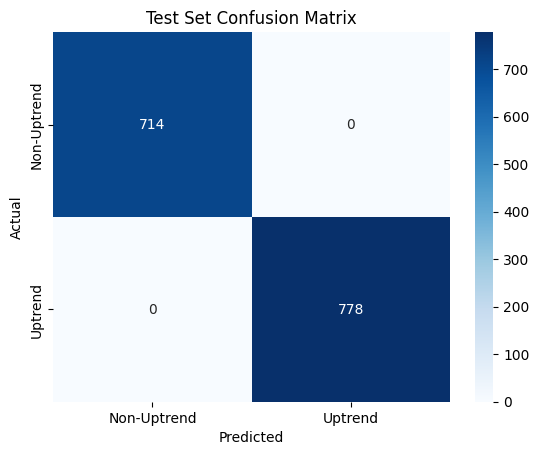


Test Set Classification Report:
                 precision    recall  f1-score   support

Non-Uptrend (0)       1.00      1.00      1.00       714
    Uptrend (1)       1.00      1.00      1.00       778

       accuracy                           1.00      1492
      macro avg       1.00      1.00      1.00      1492
   weighted avg       1.00      1.00      1.00      1492


--- 8. Backtesting the Predicted Signals ---

Backtesting Results (Test Period: 2019-01-01 to 2025-06-07):
Trading Signal Probability Threshold: 0.6
shape: (7, 3)
┌─────────────────────────────────┬──────────────────┬───────────────────────┐
│ Metric                          ┆ Trading Strategy ┆ Buy-and-Hold RELIANCE │
│ ---                             ┆ ---              ┆ ---                   │
│ str                             ┆ str              ┆ str                   │
╞═════════════════════════════════╪══════════════════╪═══════════════════════╡
│ Cumulative Return               ┆ 1402152.78%      ┆ 116.11% 

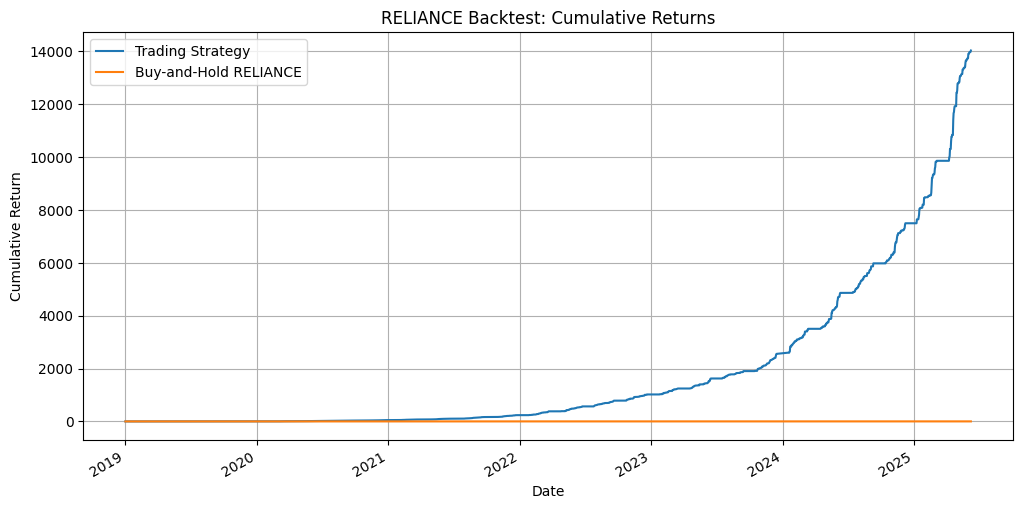

In [14]:
print("--- 1. Data Acquisition and Initial Preparation ---")
# Call the function
data_full = fetch_historical_data(
    client=client,
    symbol=SYMBOL,
    exchange=EXCHANGE,
    interval=INTERVAL,
    start_date=START_DATE,
    end_date=END_DATE_TEST
)

data_full = prepare_target_variable(data_full, DEAD_ZONE_UPPER, DEAD_ZONE_LOWER)

print("\n--- 2. Feature Engineering ---")
data_full, initial_features = engineer_features(data_full)

print("\n--- 3. Train/Validation/Test Split ---")
X_train, y_train, X_val, y_val, X_test, y_test, train_df, val_df, test_df = split_data(data_full, initial_features, END_DATE_TRAIN_VAL)

print("\n--- 4. Feature Scaling ---")
X_train_scaled_df, X_val_scaled_df, X_test_scaled_df, scaler = scale_features(X_train, X_val, X_test)

print("\n--- 5. Feature Selection Funnelling Approach ---")
X_train_final, X_val_final, X_test_final, final_selected_features = select_features(X_train_scaled_df, X_val_scaled_df, X_test_scaled_df, y_train)

print("\n--- 6. Model Building and Hyperparameter Tuning ---")
tuned_model, best_params = tune_and_train_model(X_train_final, X_val_final, y_train, y_val, RANDOM_SEED, N_OPTUNA_TRIALS, OPTUNA_CV_SPLITS)

print("\n--- 7. Model Evaluation on Test Set ---")
eval_result = evaluate_model(tuned_model, X_test_final, y_test, display_plot=True)

print("\n--- 8. Backtesting the Predicted Signals ---")
backtest_results = run_backtest(test_df, eval_result.get("probabilities"), SYMBOL, BACKTEST_PROB_THRESHOLD, RISK_FREE_RATE_ANNUAL, display_plot=True)